In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'
num_workers=0
batch_size=10

transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize((28,28)),
                            transforms.ToTensor()])

train_data=datasets.ImageFolder('../dataset/PlantVillage/train/',transform=transform)
valid_data = datasets.ImageFolder('../dataset/PlantVillage/val/',transform=transform)
test_data = datasets.ImageFolder('../dataset/test/',transform=transform)

train_loader=DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader=DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader=DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

### Visualizing a batch of training data

19 tensor(14) 14
tensor([ 7,  8, 12,  0, 12, 10, 13, 11,  7,  3,  1,  5, 10, 10,  3, 12,  0,  8,
         5, 14])


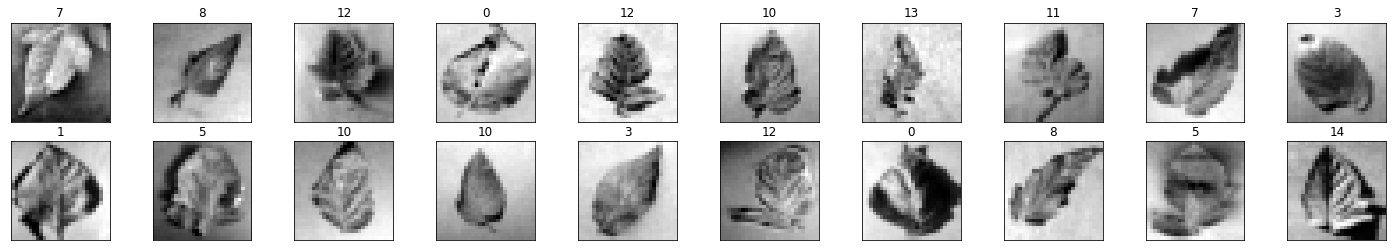

In [17]:
# dataiter= iter
images, labels= next(iter(train_loader))
images= images.numpy()

fig=plt.figure(figsize=(25,4))

for idx in np.arange(batch_size):
    ax=fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    
    ax.set_title(str(labels[idx].item()))

print(idx, labels[idx],labels[idx].item())
print(labels)

### view an image in more detail

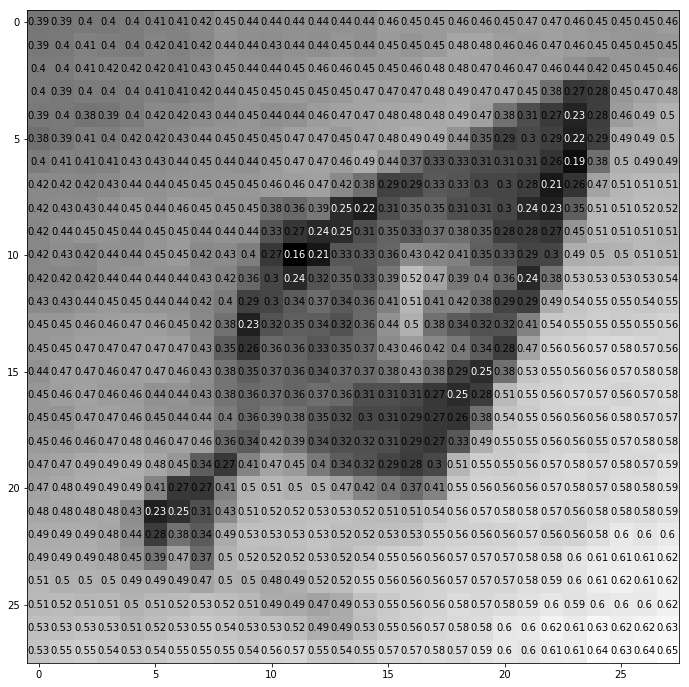

In [18]:
img=np.squeeze(images[1])

fig=plt.figure(figsize=(12,12))

ax=fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height= img.shape
thresh=img.max()/2.5

# print(width, height, thresh)

for x in range(width):
    for y in range(height):
        val= round(img[x][y],2) if img[x][y] !=0 else 0
        
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')

### Architecture

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [29]:
n_epochs=20

valid_loss_min=np.Inf
train_loss_plt=[]
valid_loss_plt = []
valid_accuracy_plt=[]
model.cuda()

for epoch in range(n_epochs):
    train_loss=0
    valid_loss=0
    
    model.train()
    for images, labels in train_loader:
        
        images, labels= images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output=model(images)
        loss=criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item() * images.size(0)
        
    model.eval()
    for images, labels in valid_loader:
        
        images, labels= images.cuda(), labels.cuda()
        output=model(images)
        
        loss=criterion(output, labels)
        
        valid_loss+= loss.item() * images.size(0)
        
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    
    train_loss_plt.append(train_loss)
    valid_loss_plt.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss,valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 216.521043 	Validation Loss: 43.264067
Validation loss decreased (inf --> 43.264067).  Saving model ...
Epoch: 2 	Training Loss: 43.626991 	Validation Loss: 43.109687
Validation loss decreased (43.264067 --> 43.109687).  Saving model ...
Epoch: 3 	Training Loss: 44.442078 	Validation Loss: 43.710981
Epoch: 4 	Training Loss: 43.656368 	Validation Loss: 43.968976
Epoch: 5 	Training Loss: 43.692727 	Validation Loss: 43.304473
Epoch: 6 	Training Loss: 43.661465 	Validation Loss: 43.263920
Epoch: 7 	Training Loss: 43.640500 	Validation Loss: 43.727669
Epoch: 8 	Training Loss: 43.623172 	Validation Loss: 43.799727
Epoch: 9 	Training Loss: 43.692760 	Validation Loss: 43.745675
Epoch: 10 	Training Loss: 43.629684 	Validation Loss: 43.457226
Epoch: 11 	Training Loss: 43.641328 	Validation Loss: 43.382870
Epoch: 12 	Training Loss: 43.657998 	Validation Loss: 43.629314
Epoch: 13 	Training Loss: 43.635616 	Validation Loss: 43.629645
Epoch: 14 	Training Loss: 43.644780 	Val

In [30]:
train_loss_list = [216.521043,43.626991,44.442078,43.656368,43.692727,43.661465,43.640500,
                  43.623172,43.692760,43.629684,43.641328,43.657998,43.635616,43.644780,43.658371,
                  43.758557,43.569849,43.636419,43.629791,43.675903]
valid_loss_list = [43.264067,43.109687,43.710981,43.968976,43.304473,43.263920,43.727669,43.799727,
                   43.745675,43.457226,43.382870,43.629314,43.629645,43.324557,43.747011,43.262875,43.603112,
                  43.615805,43.383156,43.621219]
len(train_loss_list) , len(valid_loss_list)

(20, 20)

In [ ]:
def plot(values, title, xaxis, yaxis,color):
    plt.plot(np.arange(len(values)),values, color=color)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

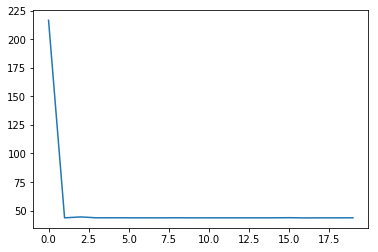

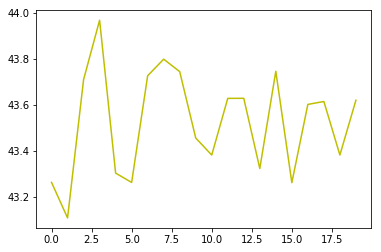

In [48]:
plt.plot(np.arange(len(train_loss_list)),train_loss_list)
plt.show()
plt.plot(np.arange(len(valid_loss_list)),valid_loss_list,color='y')
plt.show()

In [8]:
model.load_state_dict(torch.load('model.pt'))

### Test the trained n/w

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    data, target= data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.274469

Test Accuracy of     0: 94% (926/980)
Test Accuracy of     1: 96% (1093/1135)
Test Accuracy of     2: 87% (908/1032)
Test Accuracy of     3: 85% (861/1010)
Test Accuracy of     4: 94% (924/982)
Test Accuracy of     5: 90% (805/892)
Test Accuracy of     6: 95% (917/958)
Test Accuracy of     7: 94% (970/1028)
Test Accuracy of     8: 95% (929/974)
Test Accuracy of     9: 94% (949/1009)

Test Accuracy (Overall): 92% (9282/10000)
